This will be the first study for the dataset which we have just extracted.
In this work, we begin with a Feature Extractor model. Also, we will be using Clustering Algorihtm with
~ Melih Kaçaman - 12/12/2022

# Creating Data Loaders

# Setting Up Callbacks (things to run whilst our model trains)

- Model checkpoint with the ModelCheckPoint callback


In [2]:
from re import T
# Create Tensorboard callback
import datetime
import tensorflow as tf

def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving Tensorboard log files to: {log_dir}")
    return tensorboard_callback

# Creating Models Using Keras Functional API

In [5]:
SHAPE_WITH_CHANNELS = (224, 224, 3)
SHAPE = (224, 224)

In [6]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
# I'm not going to fine-tune this model.
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=SHAPE_WITH_CHANNELS, name='input_layer')
x = base_model(inputs)
outputs = tf.keras.layers.GlobalAvgPool2D(name='global_average_pooling_layer')(x)

model_0 = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 16s 1us/step


In [10]:
img_to_array_custom = tf.keras.preprocessing.image.img_to_array
load_img_custom = tf.keras.preprocessing.image.load_img

In [12]:
import tensorflow_hub as hub
import numpy as np

def get_embeddings_img(path):
    model = hub.KerasLayer('https://tfhub.dev/tensorflow/efficientnet/lite0/feature-vector/2')
    image = load_img_custom(path, target_size=SHAPE)
    image = img_to_array_custom(image)
    image = np.expand_dims(image, axis=0)

    embeddings = model(image)

    return embeddings

In [14]:
path = '../datasets/dataset_523/brand_08/1-0TK-VR033/0.jpg'
res = get_embeddings_img(path)
res.shape

<tf.Tensor: shape=(1, 1280), dtype=float32, numpy=
array([[0.03808071, 0.        , 0.52875704, ..., 0.        , 1.4017409 ,
        0.        ]], dtype=float32)>

In [18]:
type(res)

tensorflow.python.framework.ops.EagerTensor

In [21]:
type(res.numpy())

numpy.ndarray

In [22]:
res.numpy()

array([[0.03808071, 0.        , 0.52875704, ..., 0.        , 1.4017409 ,
        0.        ]], dtype=float32)

In [23]:
path = '../datasets/dataset_cv3/brand_08/1-0CD-VR029/2145.png'
res2 = get_embeddings_img(path)
res2.shape

TensorShape([1, 1280])

In [25]:
dir = '../datasets/dataset_cv3/brand_08/'
data_tf = tf.keras.preprocessing.image_dataset_from_directory(
    directory=dir,
    image_size=(224, 224),
    label_mode='categorical',
    batch_size=32
)

Found 1108 files belonging to 109 classes.


- Embeddings shapes are correct, so we can move on with tensorflow batch-dataset.

In [60]:
type(embeddings)

numpy.ndarray

In [80]:
ds = data_tf.unbatch()
images = list(ds.map(lambda x, y: x))
labels = list(ds.map(lambda x, y: y)) 

len(images), len(labels)

(1108, 1108)

In [82]:
labels[0]

<tf.Tensor: shape=(109,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.], dtype=float32)>

In [91]:
type(labels)

list

In [94]:
type(images[0])

tensorflow.python.framework.ops.EagerTensor

In [129]:
labels = np.array(labels)

In [119]:
nw_ds = np.array(list(map(lambda image: image.numpy().reshape(224, 224, 3), images)))

In [120]:
nw_ds.shape

(1108, 224, 224, 3)

In [122]:
embeddings = model_0.predict(nw_ds)

35/35 [==============================] - 57s 2s/step


In [124]:
embeddings.shape

(1108, 1280)

In [130]:
nw_ds.shape, labels.shape

((1108, 224, 224, 3), (1108, 109))

# Cluestering 

## Model C_1: 
- We will be dealing with the dataset that includes just extracted inputs using K-Means. 

In [131]:
from sklearn.cluster import KMeans

kmeans_model = KMeans(n_clusters=len(data_tf.class_names)).fit(embeddings)
kmeans_model.labels_

array([50, 55, 76, ..., 47,  1, 60])

In [132]:
len(set(kmeans_model.labels_))

109

In [168]:
kmeans_model.labels_

array([50, 55, 76, ..., 47,  1, 60])

In [166]:
kmeans_model.predict(embeddings[0, :].reshape(1, -1))

array([50])

In [167]:
kmeans_model.predict(embeddings[1, :].reshape(1, -1))

array([55])

In [147]:
unique, counts = np.unique(kmeans_model.labels_, return_counts=True)

val_counts = pd.DataFrame({'columns': unique, 'counts': counts})
val_counts.head() 

,columns,counts
0,0,3
1,1,17
2,2,21
3,3,15
4,4,6


In [153]:
np.mean(val_counts.counts)

10.1651376146789

In [154]:
val_counts[val_counts.counts == 10]

,columns,counts
5,5,10
64,64,10
94,94,10
105,105,10


In [159]:
clustering_result = pd.DataFrame({'cluster':kmeans_model.labels_})
clustering_result.head() 

,cluster
0,50
1,55
2,76
3,60
4,89


In [183]:
idxs =list( clustering_result[clustering_result.cluster == 94].index)

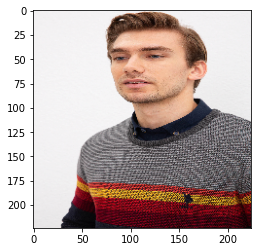

In [194]:
import matplotlib.pyplot as plt
# bir satırda 3 fotoğraf gösterme fonksiyonu yaz 
def show_images(idxs, images): 
    row = (len(idxs) / 3) 
    if len(idxs) % 3 != 0: 
        row += 1
    
    for i in range(row): 
        for j in range(3): 
            plt.subplot(1, 3, i+1)
            plt.imshow(np.array(images[idxs[]]))
            

plt.imshow(np.array(images[0],np.int32))

In [184]:
idxs

[25, 162, 224, 453, 569, 619, 929, 941, 973, 975]

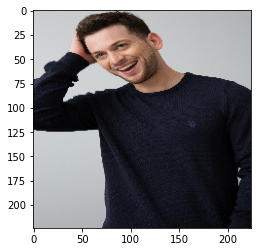

In [199]:
plt.imshow(np.array(images[25],np.int32))

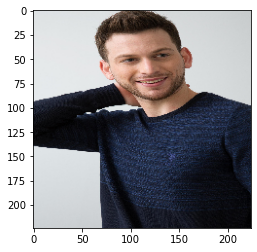

In [200]:
plt.imshow(np.array(images[162],np.int32))

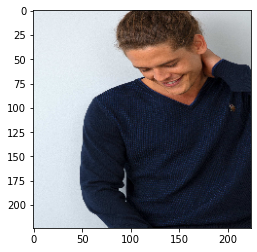

In [201]:
plt.imshow(np.array(images[224],np.int32))

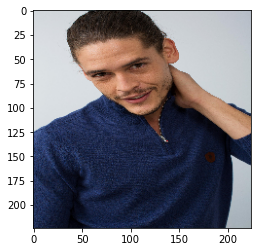

In [202]:
plt.imshow(np.array(images[453],np.int32))

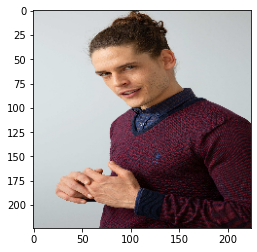

In [203]:
plt.imshow(np.array(images[569],np.int32))

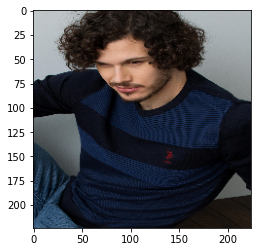

In [204]:
plt.imshow(np.array(images[619],np.int32))

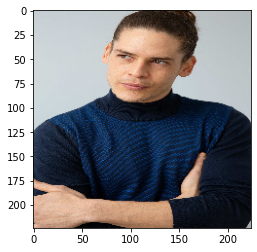

In [205]:
plt.imshow(np.array(images[929],np.int32))

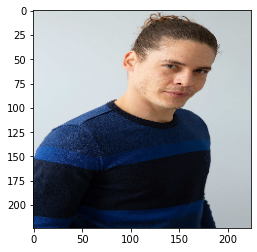

In [206]:
plt.imshow(np.array(images[941],np.int32))

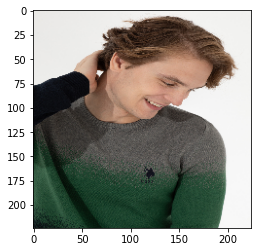

In [207]:
plt.imshow(np.array(images[973],np.int32))

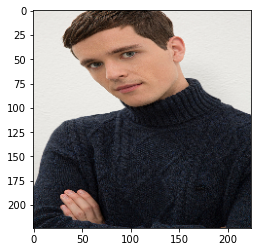

In [208]:
plt.imshow(np.array(images[975],np.int32))